In [1]:
# Import the necessary libraries
import pandas as pd
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ReduceLROnPlateau, 
    ModelCheckpoint, 
    TensorBoard,
    CSVLogger
)
import os
from datetime import datetime
import numpy as np
from sklearn.model_selection import KFold
# Import the necessary libraries



# Define the file paths
subdirectory = "pickle_data_Saisonbrot"
training_features_path = f"{subdirectory}/training_features.pkl"
validation_features_path = f"{subdirectory}/validation_features.pkl"
test_features_path = f"{subdirectory}/test_features.pkl"
training_labels_path = f"{subdirectory}/training_labels.pkl"
validation_labels_path = f"{subdirectory}/validation_labels.pkl"
test_labels_path = f"{subdirectory}/test_labels.pkl"

# Read the pickle files
training_features = pd.read_pickle(training_features_path)
validation_features = pd.read_pickle(validation_features_path)
test_features = pd.read_pickle(test_features_path)
training_labels = pd.read_pickle(training_labels_path)
validation_labels = pd.read_pickle(validation_labels_path)
#test_labels = pd.read_pickle(test_labels_path)

# Verify the loaded data by printing their shapes and a few rows
print("Loaded Training features dimensions:", training_features.shape)
print("Loaded Validation features dimensions:", validation_features.shape)
print("Loaded Test features dimensions:", test_features.shape)
print()
print("Loaded Training labels dimensions:", training_labels.shape)
print("Loaded Validation labels dimensions:", validation_labels.shape)
#print("Loaded Test labels dimensions:", test_labels.shape)
print()

print("First few rows of loaded training features:")
print(training_features.head())
print()
print("First few rows of loaded training labels:")
print(training_labels.head())


2025-01-08 15:43:14.912268: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 15:43:14.931211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736347394.953911 4100299 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736347394.959419 4100299 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 15:43:14.978407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loaded Training features dimensions: (236, 24)
Loaded Validation features dimensions: (56, 24)
Loaded Test features dimensions: (56, 24)

Loaded Training labels dimensions: (236, 1)
Loaded Validation labels dimensions: (56, 1)

First few rows of loaded training features:
      Temp_Cold_current  Temp_Mild_current  Cloud_Clear_current  \
9042                  0                  1                    0   
9043                  0                  1                    0   
9044                  0                  1                    0   
9045                  0                  1                    0   
9046                  0                  1                    0   

      Cloud_Cloudy_current  Weather_Moderate_current  Samstag_current  \
9042                     0                         0                0   
9043                     1                         0                0   
9044                     0                         0                1   
9045                     1       

In [2]:
class BayesianNeuralTuner:
    def __init__(
        self,
        input_shape,
        max_trials=10,
        project_name='nn_tuning',
        log_dir='logs/Saisonbrot',
        n_folds=3
    ):
        self.input_shape = input_shape
        self.max_trials = max_trials
        self.project_name = project_name
        self.log_dir = os.path.join(log_dir, datetime.now().strftime("%Y%m%d-%H%M%S"))
        self.n_folds = n_folds
        os.makedirs(self.log_dir, exist_ok=True)
        
    def build_model(self, hp):
        # Use factors of 2 for more efficient GPU utilization
        units1_choices = [32, 64, 96, 128]
        units2_choices = [16, 32, 48, 64]
        
        model = Sequential([
            InputLayer(shape=self.input_shape),
            
            # First dropout with tunable rate
            Dropout(hp.Float('dropout1', 0.1, 0.3, step=0.1)),
            
            # First dense layer with conditional units
            Dense(
                units=hp.Choice('units1', units1_choices),
                activation='relu',
                kernel_regularizer=l2(hp.Float(
                    'l2_reg1', 
                    1e-4, 
                    1e-2, 
                    sampling='log'
                )),
                kernel_initializer='he_normal'
            ),
            
            # Second dense layer with conditional units
            Dense(
                units=hp.Choice('units2', units2_choices),
                activation='relu',
                kernel_regularizer=l2(hp.Float(
                    'l2_reg2', 
                    1e-4, 
                    1e-2, 
                    sampling='log'
                )),
                kernel_initializer='he_normal'
            ),
            
            Dense(1)
        ])
        
        # Learning rate with warm restarts
        base_lr = hp.Float(
            'base_learning_rate',
            min_value=1e-4,
            max_value=1e-2,
            sampling='log'
        )
        
        # Optimizer with tunable parameters
        optimizer = AdamW(
            learning_rate=base_lr,
            beta_1=hp.Float('beta_1', 0.9, 0.999),
            beta_2=hp.Float('beta_2', 0.9, 0.999),
            weight_decay=hp.Float('weight_decay', 1e-4, 1e-2, sampling='log')
        )
        
        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mape']
        )
        
        return model
    
    def get_callbacks(self, checkpoint_path, fold=None):
        fold_suffix = f'_fold_{fold}' if fold is not None else ''
        return [
            EarlyStopping(
                monitor='val_mape',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_mape',
                factor=0.5,
                patience=3,
                min_lr=1e-6,
                verbose=1
            ),
            ModelCheckpoint(
                filepath=checkpoint_path.format(fold=fold_suffix),
                monitor='val_mape',
                save_best_only=True,
                verbose=1
            ),
            TensorBoard(
                log_dir=os.path.join(self.log_dir, f'fold{fold_suffix}'),
                histogram_freq=1,
                write_graph=True
            ),
            CSVLogger(
                os.path.join(self.log_dir, f'training_log{fold_suffix}.csv'),
                separator=',',
                append=False
            )
        ]
    
    def cross_validate_hyperparameters(self, hp, x, y, batch_size):
        """Perform k-fold cross-validation for a set of hyperparameters"""
        kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        scores = []
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(x)):
            x_train_fold = x[train_idx]
            y_train_fold = y[train_idx]
            x_val_fold = x[val_idx]
            y_val_fold = y[val_idx]
            
            model = self.build_model(hp)
            checkpoint_path = os.path.join(self.log_dir, 'model_cv_{fold}.h5')
            callbacks = self.get_callbacks(checkpoint_path, fold)
            
            model.fit(
                x_train_fold,
                y_train_fold,
                epochs=100,
                batch_size=batch_size,
                validation_data=(x_val_fold, y_val_fold),
                callbacks=callbacks,
                verbose=0
            )
            
            scores.append(model.evaluate(x_val_fold, y_val_fold)[0])
        
        return np.mean(scores)
    
    def search(self, training_features, training_labels, validation_data, batch_size=24):
        checkpoint_path = os.path.join(self.log_dir, 'best_model.keras')
        
        # Initialize Bayesian Optimization tuner
        tuner = kt.BayesianOptimization(
            self.build_model,
            objective=kt.Objective('val_mape', direction='min'),
            max_trials=self.max_trials,
            directory=self.log_dir,
            project_name=self.project_name,
            overwrite=True
        )
        
        # Print search space summary
        tuner.search_space_summary()
        
        # Implement early stopping for the hyperparameter search
        stop_early = EarlyStopping(
            monitor='val_mape',
            min_delta=1e-4,
            patience=3
        )
        
        # Search with cross-validation
        tuner.search(
            training_features,
            training_labels,
            epochs=100,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=self.get_callbacks(checkpoint_path),
            verbose=1
        )
        
        # Get best hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        
        # Print detailed results
        print("\nBest Hyperparameters:")
        for param, value in best_hps.values.items():
            print(f"{param}: {value}")
        
        # Build and train final model with best parameters
        best_model = tuner.hypermodel.build(best_hps)
        
        history = best_model.fit(
            training_features,
            training_labels,
            epochs=100,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=self.get_callbacks(checkpoint_path),
            verbose=1
        )
        
        return best_model, history, best_hps


In [3]:

tuner = BayesianNeuralTuner(
    input_shape=(training_features.shape[1],),
    max_trials=20,
    n_folds=3
)

best_model, history, best_hps = tuner.search(
    training_features,
    training_labels,
    validation_data=(validation_features, validation_labels)
)

Trial 20 Complete [00h 00m 38s]
val_mape: 41.302833557128906

Best val_mape So Far: 34.360084533691406
Total elapsed time: 00h 06m 33s

Best Hyperparameters:
dropout1: 0.1
units1: 96
l2_reg1: 0.007181490911492214
units2: 64
l2_reg2: 0.000560184624787185
base_learning_rate: 0.005529023837534512
beta_1: 0.993259028481014
beta_2: 0.9143088486027919
weight_decay: 0.00019617145132549103
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 5107.6611 - mape: 91.2900
Epoch 1: val_mape improved from inf to 64.29261, saving model to logs/Saisonbrot/20250108-154317/best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 5058.5381 - mape: 90.6133 - val_loss: 3061.6589 - val_mape: 64.2926 - learning_rate: 0.0055
Epoch 2/100
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3260.4114 - mape: 56.8710
Epoch 2: val_mape improved from 64.29261 to 57.41815, saving model to logs/Saisonbrot/20250108-154317/best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 2825.6399 - mape: 53

In [4]:
early_stopping = EarlyStopping(
    monitor='val_mape',  # Überwachung der Validierungsverlust
    patience=20,         # Anzahl der Epochen ohne Verbesserung
    restore_best_weights=True  # Stellt das Modell mit den besten Gewichten wieder her
)
# Train the final model
history = best_model.fit(
    training_features,
    training_labels,
    epochs=100,
    batch_size=24,
    validation_data=(validation_features, validation_labels),
    callbacks=[early_stopping]
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 857.1214 - mape: 33.8471 - val_loss: 579.5891 - val_mape: 31.0011
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 943.9614 - mape: 34.1302 - val_loss: 785.5367 - val_mape: 32.6177
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1248.6302 - mape: 35.8648 - val_loss: 934.8012 - val_mape: 35.0908
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1453.2362 - mape: 37.3533 - val_loss: 988.1525 - val_mape: 36.2574
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1462.7390 - mape: 37.1135 - val_loss: 954.9733 - val_mape: 36.1873
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1276.5201 - mape: 34.6056 - val_loss: 856.2126 - val_mape: 36.2992
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1307.5770 - mape: 32.2659 - val_loss: 729.7939 - val_mape: 37.3015
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 874.5763 - mape: 32.2855 - val_loss: 639.8375 - val_m

In [5]:
model = best_model

# Saving the trained Model
best_model.save("python_model_Saisonbrot.h5")

In [6]:
# Making Predictions and Evaluating the Model
import numpy as np

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

training_predictions = best_model.predict(training_features)
validation_predictions = best_model.predict(validation_features)
print(f"MAPE on the Training Data: {mape(training_labels, training_predictions):.2f}%")
print(f"MAPE on the Validation Data: {mape(validation_labels, validation_predictions):.2f}%")

2025-01-08 15:50:04.624958: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_16', 8 bytes spill stores, 8 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
MAPE on the Training Data: 32.60%
MAPE on the Validation Data: 31.00%


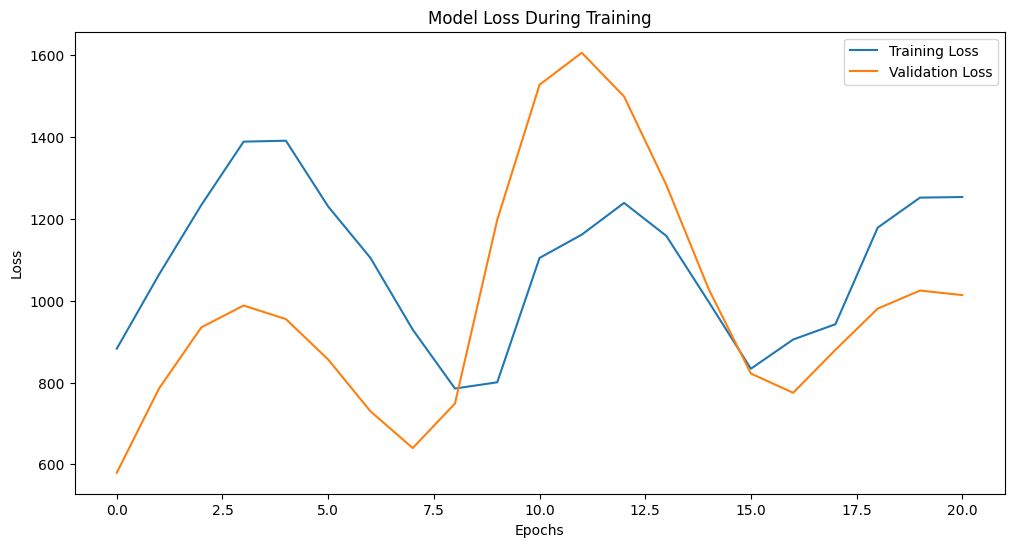

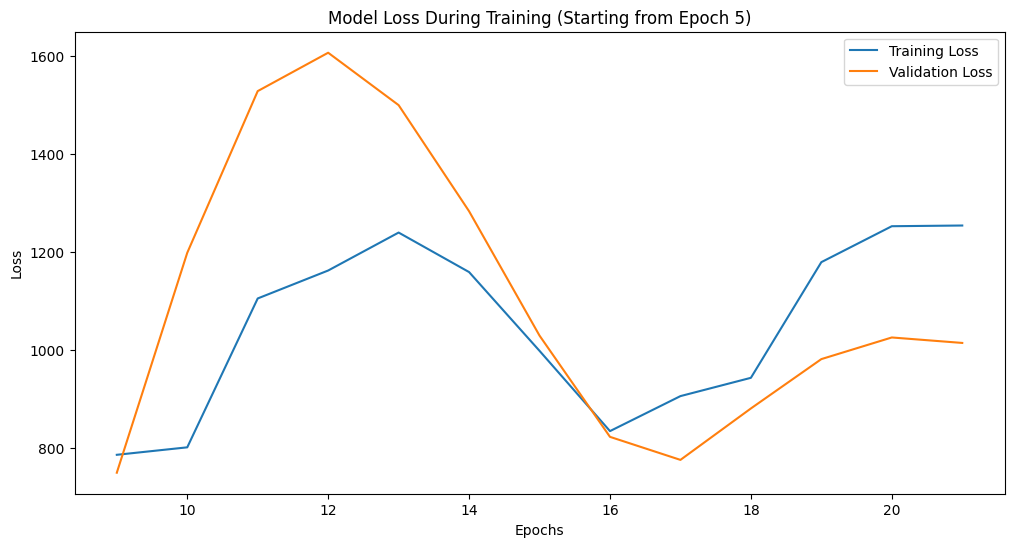

In [7]:
# Plotting Training History
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training History (ab der 5. Epoche)
import matplotlib.pyplot as plt

# Schneide die Verlaufsdaten ab der 5. Epoche
epochs_to_plot = range(9, len(history.history['loss']) + 1)
training_loss = history.history['loss'][8:]
validation_loss = history.history['val_loss'][8:]

plt.figure(figsize=(12, 6))
plt.plot(epochs_to_plot, training_loss, label='Training Loss')
plt.plot(epochs_to_plot, validation_loss, label='Validation Loss')
plt.title('Model Loss During Training (Starting from Epoch 5)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


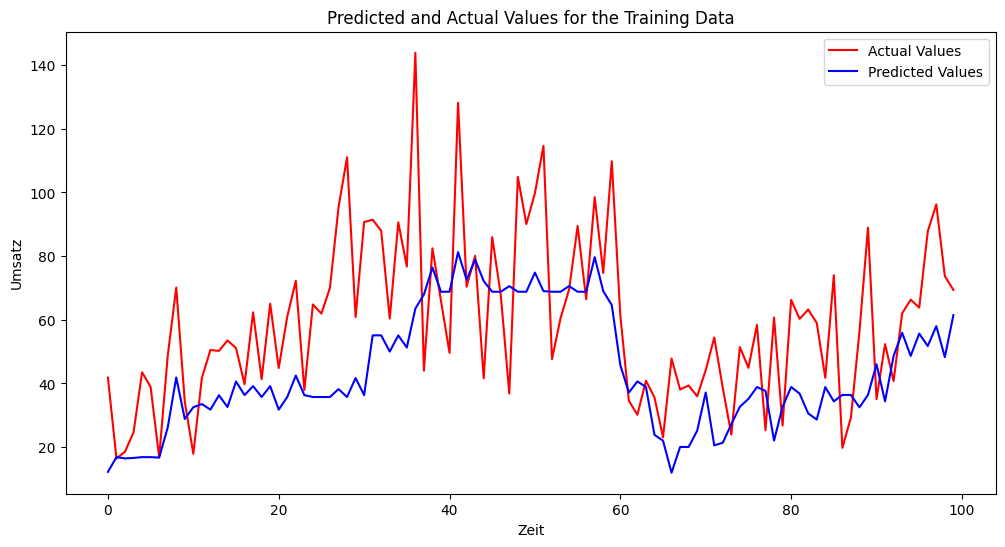

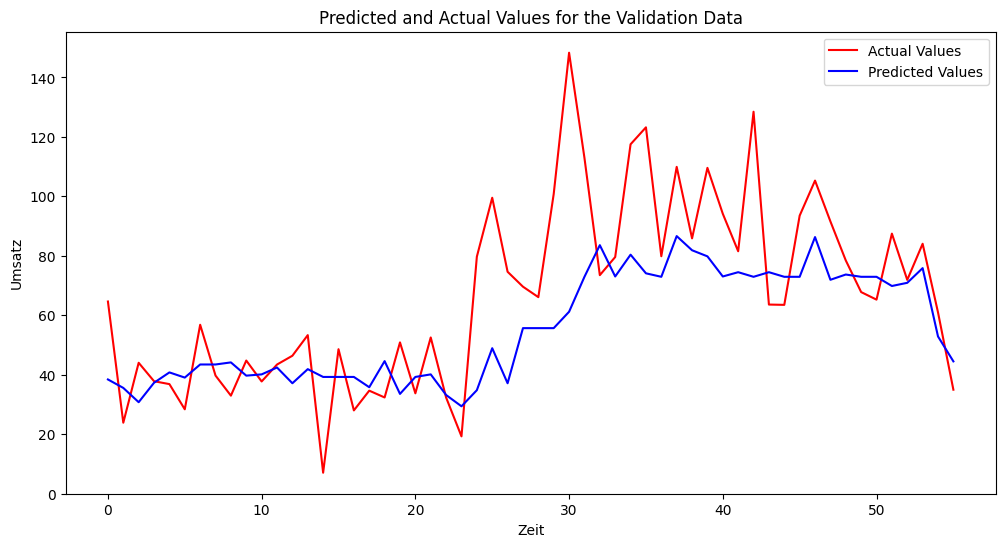

In [8]:
def plot_predictions(data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data['actual'], label='Actual Values', color='red')
    plt.plot(data['prediction'], label='Predicted Values', color='blue')
    plt.title(title)
    plt.xlabel('Zeit')
    plt.ylabel('Umsatz')
    plt.legend()
    plt.show()

# Ensure that training_predictions, validation_predictions, training_labels, and validation_labels are numpy arrays
training_predictions = np.array(training_predictions).flatten()
validation_predictions = np.array(validation_predictions).flatten()
training_labels = np.array(training_labels).flatten()
validation_labels = np.array(validation_labels).flatten()

# print the type of the predictions
print(type(training_predictions))
print(type(validation_predictions))

# Create DataFrames with 1-dimensional arrays
data_train = pd.DataFrame({'prediction': training_predictions, 'actual': training_labels})
data_validation = pd.DataFrame({'prediction': validation_predictions, 'actual': validation_labels})

# Plot predictions
plot_predictions(data_train.head(100), 'Predicted and Actual Values for the Training Data')
plot_predictions(data_validation.head(100), 'Predicted and Actual Values for the Validation Data')

***VORHERSAGE TESTZEITRAUM***

In [9]:
test_predictions = best_model.predict(test_features)
#print("Predictions for test data:", test_predictions[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", test_predictions.shape)
test_predictions = pd.DataFrame(test_predictions)
test_predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Größe des Arrays (shape): (56, 1)


,0
0,26.217524
1,31.705149
2,48.738201
3,39.660515
4,37.411995
5,38.076504
6,39.306789
7,36.185680
8,38.076504
9,41.559479


In [10]:
data_test = pd.read_csv("../../../0_DataPreparation/00_data/data_with_lag/Testdaten_with_lag.csv")
data_test = data_test[data_test["Warengruppe_6"] == 1]
data_test

,id,Datum,Warengruppe_1,Warengruppe_2,Warengruppe_3,Warengruppe_4,Warengruppe_5,Warengruppe_6,Temp_Very_Cold_current,Temp_Very_Cold_prev,...,zwischen_den_jahren_next,Number_of_ships_scaled_current,Number_of_ships_scaled_prev,Number_of_ships_scaled_next,Cloud_ok_current,Cloud_ok_prev,Cloud_ok_next,Wind_ok_current,Wind_ok_prev,Wind_ok_next
1774,1811016,2018-11-01,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.2,0.0,1,0.0,0.0,1,1.0,1.0
1775,1811026,2018-11-02,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0,1.0,1.0,1,1.0,1.0
1776,1811036,2018-11-03,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,1,0.0,0.0,1,1.0,1.0
1777,1811046,2018-11-04,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.2,0,1.0,0.0,1,1.0,1.0
1778,1811056,2018-11-05,0,0,0,0,0,1,0,0.0,...,0.0,0.2,0.0,0.2,0,0.0,0.0,1,1.0,1.0
1779,1811066,2018-11-06,0,0,0,0,0,1,0,0.0,...,0.0,0.2,0.2,0.4,0,0.0,1.0,1,1.0,1.0
1780,1811076,2018-11-07,0,0,0,0,0,1,0,0.0,...,0.0,0.4,0.2,1.0,1,0.0,0.0,1,1.0,1.0
1781,1811086,2018-11-08,0,0,0,0,0,1,0,0.0,...,0.0,1.0,0.4,0.2,0,1.0,0.0,1,1.0,1.0
1782,1811096,2018-11-09,0,0,0,0,0,1,0,0.0,...,0.0,0.2,1.0,0.0,0,0.0,0.0,1,1.0,1.0
1783,1811106,2018-11-10,0,0,0,0,0,1,0,0.0,...,0.0,0.0,0.2,0.0,0,0.0,0.0,1,1.0,1.0


In [11]:
# Erstelle Ziel csv Datei

predictions_df = pd.DataFrame({
    'id': data_test['id'].values,
    'Umsatz': test_predictions[0].values
}).reset_index(drop=True)

# Save to a CSV file
#output_csv_path = "/workspaces/bakery_sales_prediction/3_Model/02_Franz/V3_lag/Umsatzvorhersage_Saisonbrot_Hochladeformat.csv"

predictions_df.to_csv('Saisonbrot_Umsatzvorhersage.csv', index=False)
print(f"CSV Datei erstellt")

CSV Datei erstellt
